Original code: https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend

Dataset (GTZAN): https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

# 데이터셋 다운로드

In [1]:
from dotenv import load_dotenv
import os


dotenv_path = '.env'
load_dotenv(dotenv_path=dotenv_path)

KAGGLE_USERNAME = os.getenv('KAGGLE_USERNAME')
KAGGLE_KEY = os.getenv('KAGGLE_KEY')

In [80]:
if not os.path.exists('Data'):
    !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
    !unzip -q gtzan-dataset-music-genre-classification.zip
else:
    print("GTZAN 데이터가 이미 존재합니다.")

100%|██████████████████████████████████████| 1.21G/1.21G [01:55<00:00, 10.1MB/s]
100%|██████████████████████████████████████| 1.21G/1.21G [01:55<00:00, 11.3MB/s]


# 오디오 파일 이해하기

- y: 소리가 떨리는 세기(진폭)를 시간 순서대로 나열한 것
- Sampling rate: 1초당 샘플의 개수, 단위 Hz 또는 kHz

In [4]:
import librosa


y, sr = librosa.load('Data/genres_original/reggae/reggae.00036.wav')

print(y)
print(len(y))
print('Sampling rate (Hz): %d' % sr)
print('Audio length (seconds): %.2f' % (len(y) / sr))

[0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388]
661794
Sampling rate (Hz): 22050
Audio length (seconds): 30.01


## 음악 들어보기

In [5]:
import IPython.display as ipd

ipd.Audio(y, rate=sr)

## 2D 음파 그래프

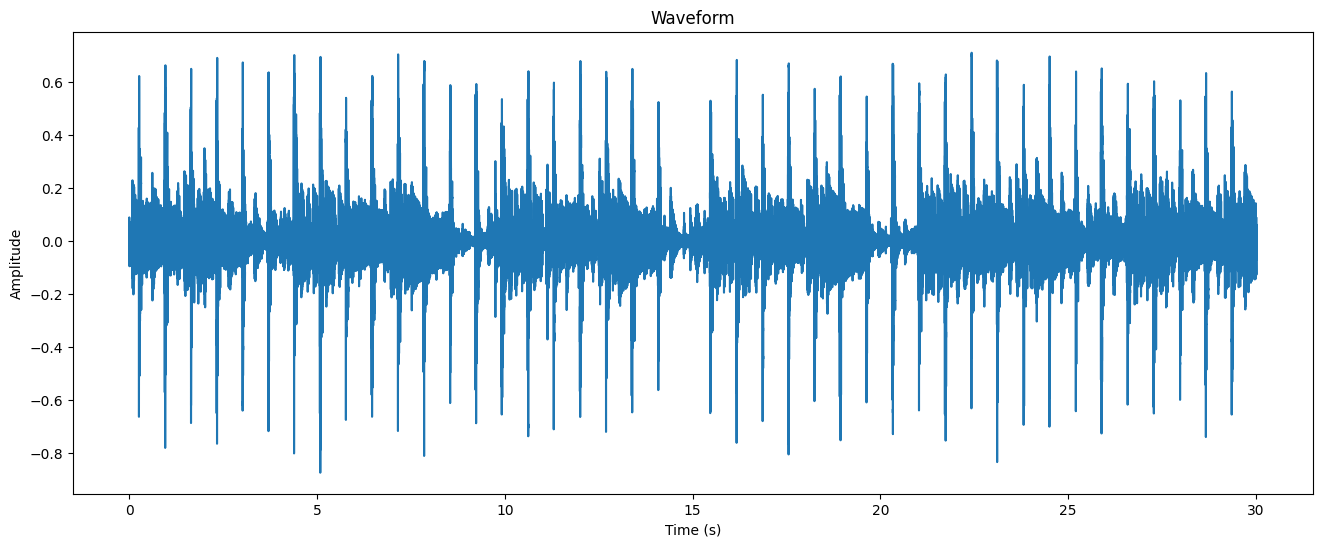

In [6]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

times = np.arange(len(y)) / sr

plt.figure(figsize=(16, 6))
plt.plot(times, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

## Fourier Transform

- 시간 영역 데이터를 주파수 영역으로 변경
- y축: 주파수 (로그 스케일)
- color축: 데시벨 (진폭)

(1025, 1293)


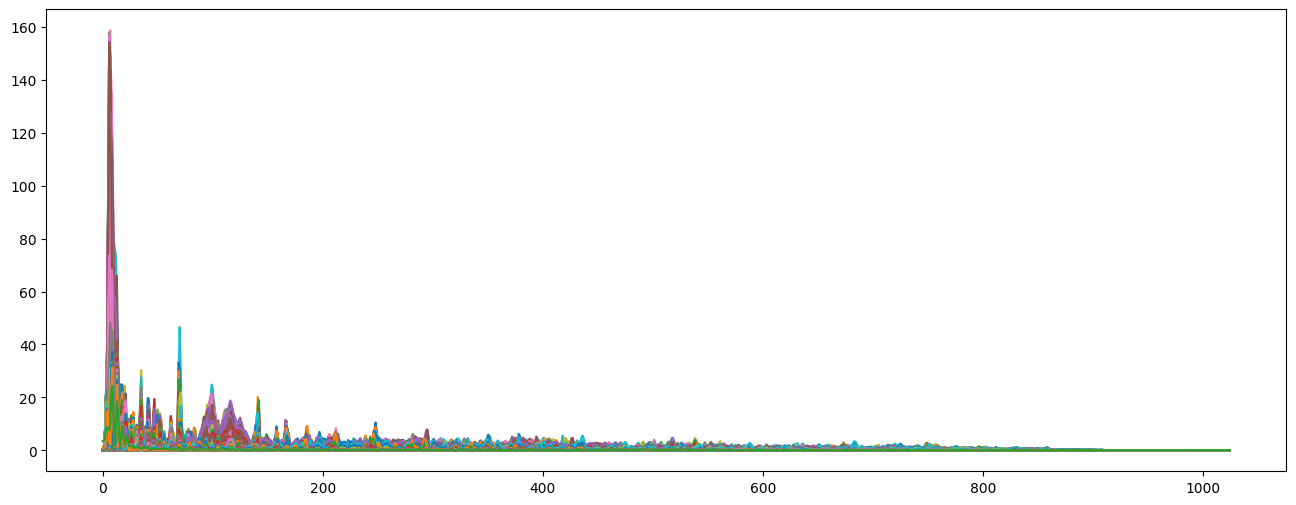

In [7]:
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))

print(D.shape)

plt.figure(figsize=(16, 6))
plt.plot(D)
plt.show()

## Spectogram

- 시간에 따른 신호 주파수의 스펙트럼 그래프
- 다른 이름: Sonographs, Voiceprints, Voicegrams

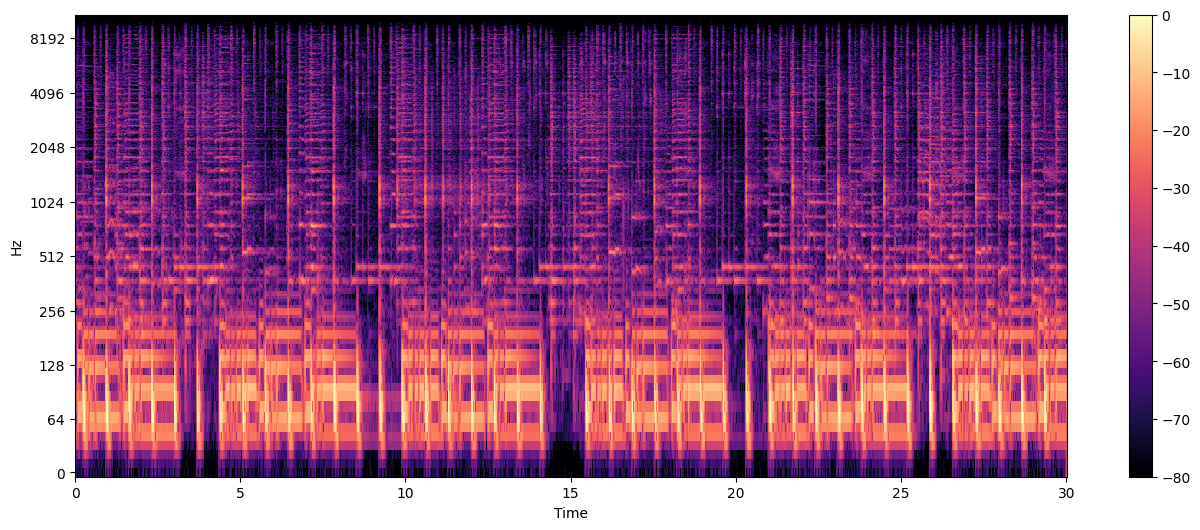

In [8]:
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

## Mel Spectogram

- (인간이 이해하기 힘든) Spectogram의 y축을 Mel Scale로 변환한 것 (Non-linear transformation)
- Mel Scale: https://newsight.tistory.com/294

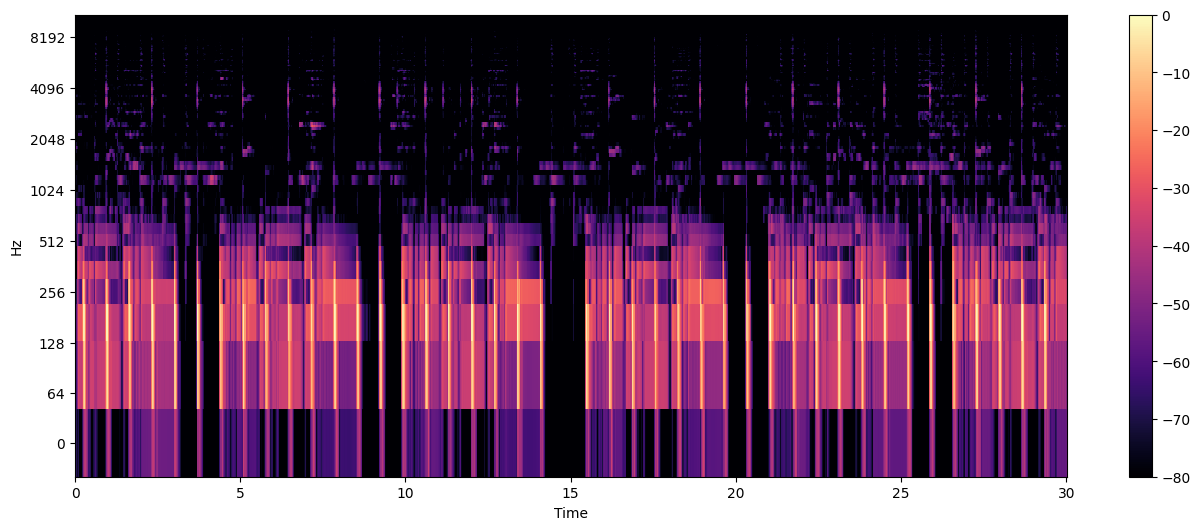

In [9]:
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

## 레게 vs 클래식 Mel Spectogram

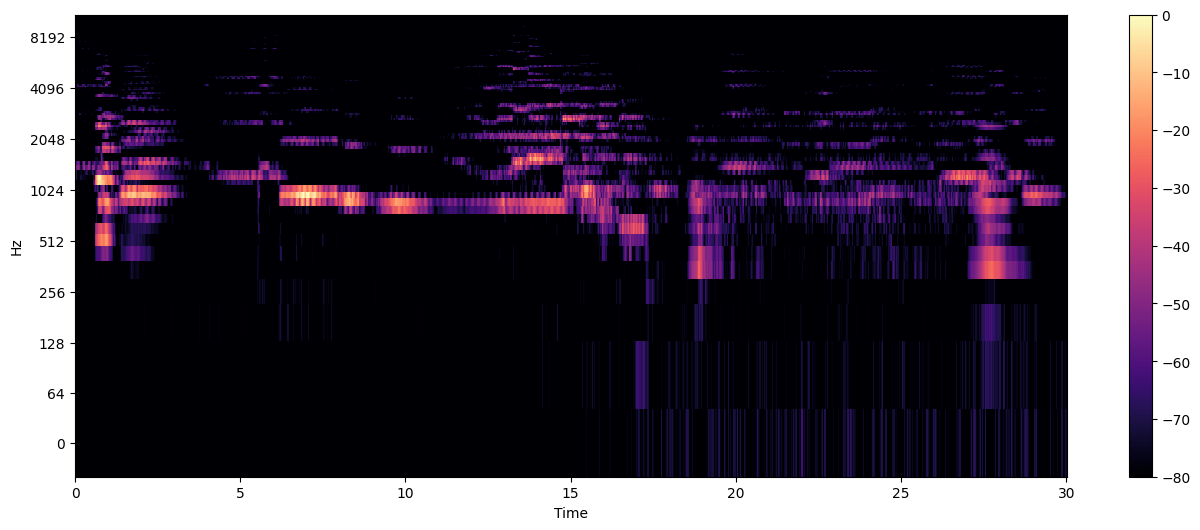

In [10]:
y, sr = librosa.load('Data/genres_original/classical/classical.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis = 'time', y_axis = 'log')
plt.colorbar()
plt.show()

# 오디오 특성 추출 (Audio Feature Extraction)

## Tempo (BPM)

In [11]:
tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
print(tempo)

107.666015625


## Zero Crossing Rate

- 음파가 양에서 음으로 또는 음에서 양으로 바뀌는 비율

In [12]:
zero_crossings = librosa.zero_crossings(y=y, pad=False)

print(zero_crossings)
print(sum(zero_crossings))

[False False False ... False False False]
39405


### 확대해서 보자

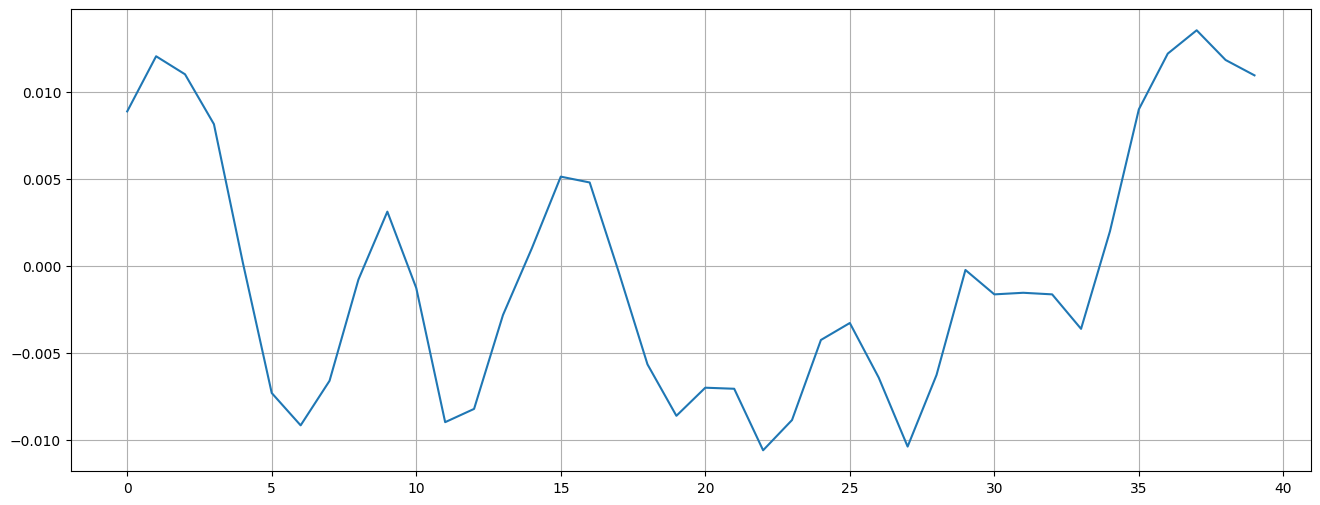

In [13]:
n0 = 9000
n1 = 9040

plt.figure(figsize=(16, 6))
plt.plot(y[n0:n1])
plt.grid()
plt.show()

In [14]:
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
print(sum(zero_crossings))

6


## Harmonic and Percussive Components

- Harmonics: 사람의 귀로 구분할 수 없는 특징들 (음악의 색깔)
- Percussives: 리듬과 감정을 나타내는 충격파

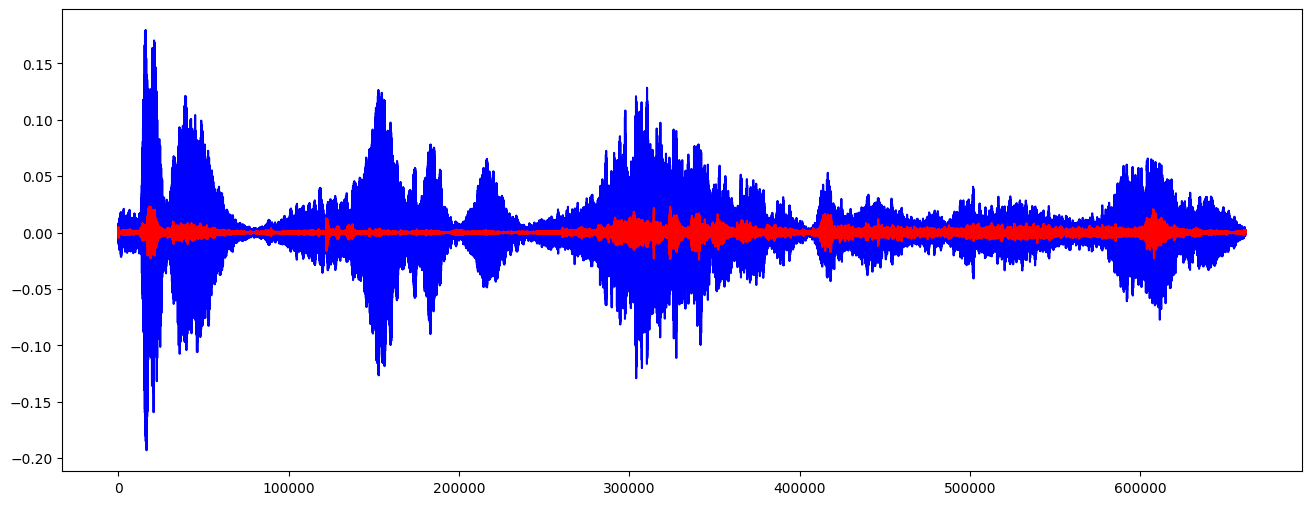

In [15]:
y_harm, y_perc = librosa.effects.hpss(y)

plt.figure(figsize=(16, 6))
plt.plot(y_harm, color='b')
plt.plot(y_perc, color='r')
plt.show()

## Spectral Centroid

- 소리를 주파수 표현했을 때, 주파수의 가중평균을 계산하여 소리의 "무게 중심"이 어딘지를 알려주는 지표
- 예를 들어, 블루스 음악은 무게 중심이 가운데 부분에 놓여있는 반면, 메탈 음악은 (끝 부분에서 달리기 때문에) 노래의 마지막 부분에 무게 중심이 실린다

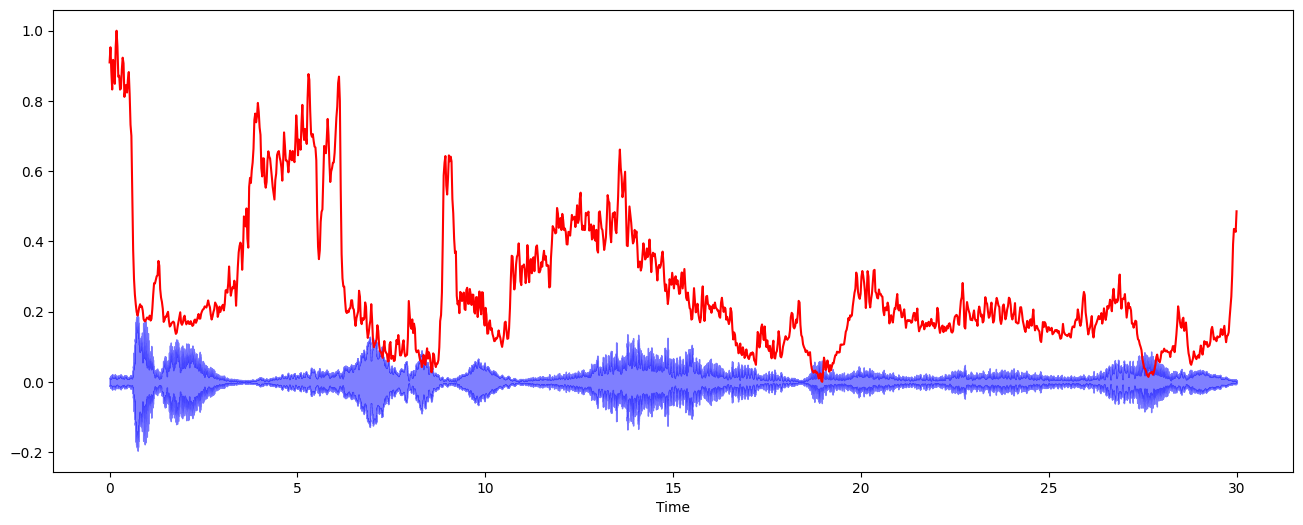

In [16]:
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

import sklearn
def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)

plt.figure(figsize=(16, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()

## Spectral Rolloff

- 신호 모양을 측정한다
- 총 스펙트럴 에너지 중 낮은 주파수(85% 이하)에 얼마나 많이 집중되어 있는가

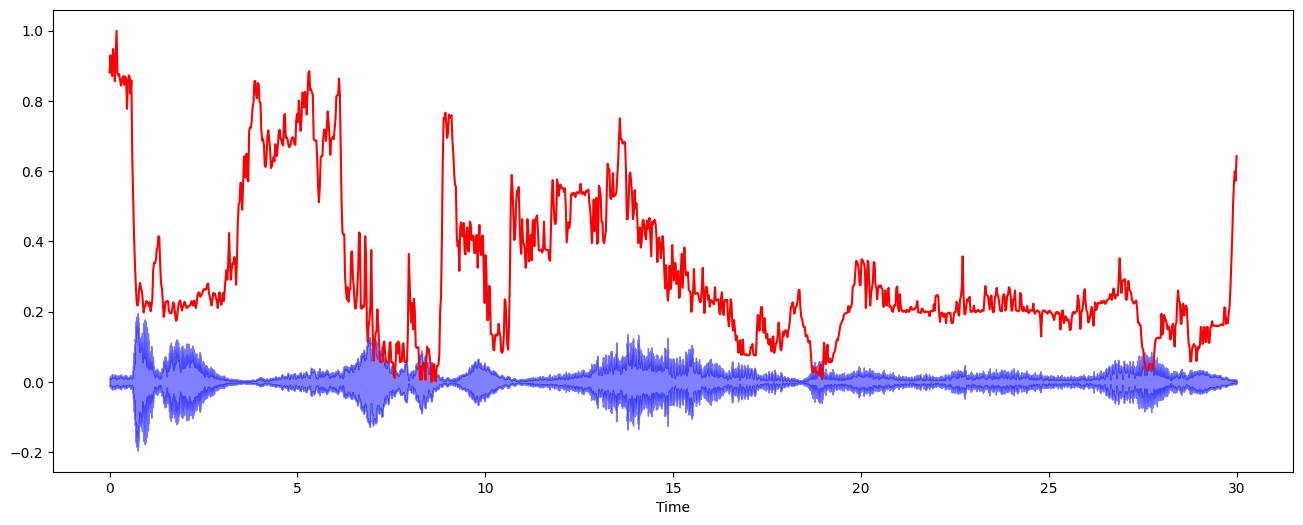

In [17]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

plt.figure(figsize=(16, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.show()

## Mel-Frequency Cepstral Coefficients (MFCCs)

- MFCCs는 특징들의 작은 집합(약 10-20)으로 스펙트럴 포곡선의 전체적인 모양을 축약하여 보여준다
- 사람의 청각 구조를 반영하여 음성 정보 추출
- https://tech.kakaoenterprise.com/66

mean: 0.49
var: 0.04


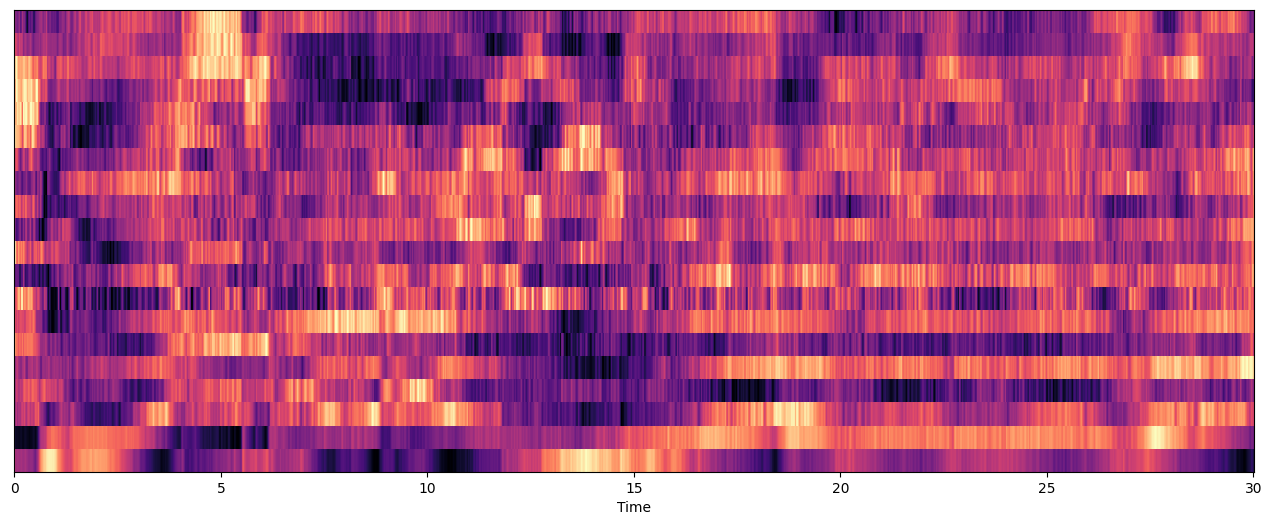

In [18]:
mfccs = librosa.feature.mfcc(y=y, sr=sr)
mfccs = normalize(mfccs, axis=1)

print('mean: %.2f' % mfccs.mean())
print('var: %.2f' % mfccs.var())

plt.figure(figsize=(16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

## Chroma Frequencies

- 크로마 특징은 음악의 흥미롭고 강렬한 표현이다
- 크로마는 인간 청각이 옥타브 차이가 나는 주파수를 가진 두 음을 유사음으로 인지한다는 음악이론에 기반한다
- 모든 스펙트럼을 12개의 Bin으로 표현한다
- 12개의 Bin은 옥타브에서 12개의 각기 다른 반음(Semitones=Chroma)을 의미한다

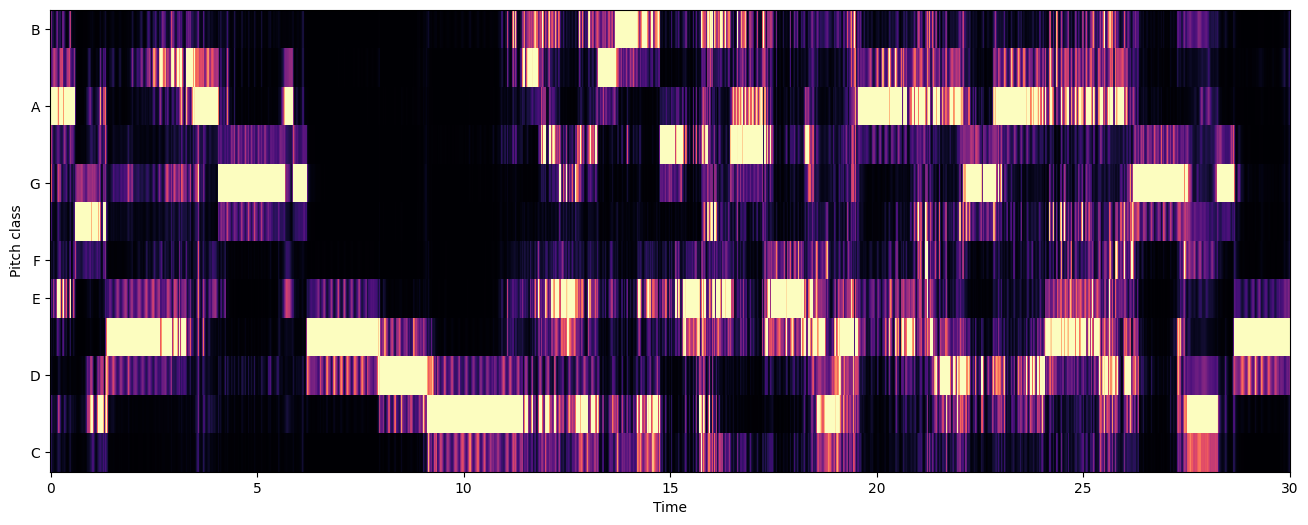

In [19]:
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

# 학습

## 데이터셋 로드

In [20]:
import pandas as pd

df = pd.read_csv('Data/features_30_sec.csv')

df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

## 전처리

In [21]:
import sklearn
import pickle
import os


MODELS = "Cache/"
cache_dir = os.path.join(os.getcwd(), 'Cache')
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

X = df.drop(columns=[
    'filename', 
    'length', 
    'label', 
    'perceptr_mean', 
    'perceptr_var'
    ])
y = df['label']

scaler = sklearn.preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)

with open(f'{MODELS}/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

X = pd.DataFrame(np_scaled, columns=X.columns)

X.head()

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0          0.362279         0.695468  0.318188  0.101983   
1          0.343622         0.793392  0.230894  0.085580   
2          0.389832         0.640692  0.433652  0.099064   
3          0.473508         0.777954  0.345856  0.229160   
4          0.277759         0.681062  0.219641  0.083075   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                0.314117               0.040233                 0.422879   
1                0.248405               0.121475                 0.436889   
2                0.254261               0.049046                 0.325334   
3                0.129376               0.058253                 0.267404   
4                0.327270               0.110761                 0.325514   

   spectral_bandwidth_var  rolloff_mean  rolloff_var  ...  mfcc16_mean  \
0                0.109789      0.385532     0.102567  ...     0.564186   
1                0.296867      0.353329     0.342717  ...     0.570198   
2                0.095712      0.289224     0.088981  ...     0.622467   
3                0.227566      0.181068     0.171001  ...     0.565151   
4                0.113536      0.357017     0.180228  ...     0.383289   

   mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
0    0.112704     0.541287    0.057615     0.422444    0.082450     0.487950   
1    0.120353     0.574685    0.118286     0.448184    0.102997     0.548800   
2    0.081898     0.331003    0.085962     0.370988    0.116420     0.453724   
3    0.091876     0.484549    0.092509     0.460684    0.068975     0.538690   
4    0.200462     0.410225    0.156424     0.403875    0.120300     0.424652   

   mfcc19_var  mfcc20_mean  mfcc20_var  
0    0.109503     0.599189    0.078255  
1    0.099081     0.579640    0.075947  
2    0.087317     0.501381    0.045405  
3    0.062612     0.468060    0.048168  
4    0.130173     0.233047    0.094836  

[5 rows x 55 columns]

## 학습 및 검증

In [22]:
# SEED 고정
SEED = 2021

In [23]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

## XGBoost

In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV


# 하이퍼 파라미터 세팅
param_distributions = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'colsample_bytree': [0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1]
}

# 레이블을 문자열에서 정수로 인코딩 및 디코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 모델 세팅
xgb = XGBClassifier(random_state=SEED)
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=10,  # 시도할 하이퍼파라미터 조합 수
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=SEED
)

# 모델 학습
random_search_xgb.fit(X_train, y_train_encoded)

# 결과 출력
print(f"Best parameters found: {random_search_xgb.best_params_}")
print(f"Best CV score: {random_search_xgb.best_score_}")

# 최적의 하이퍼파라미터로 학습된 모델을 저장
best_xgb_model = random_search_xgb.best_estimator_
best_xgb_model.save_model(f'{MODELS}xgb_model.json')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best CV score: 0.7150131884017159


### Cross Validation Score

In [25]:
from sklearn.model_selection import cross_val_score


y_pred = best_xgb_model.predict(X_test)
test_accuracy = accuracy_score(y_test_encoded, y_pred)
cross_val_accuracy = cross_val_score(xgb, X, y_encoded, cv=5, n_jobs=-1)

print(f"Test set Accuracy: {test_accuracy * 100:.2f}%")
print(f'Mean CV Accuracy: {cross_val_accuracy.mean() * 100:.2f}%')

Test set Accuracy: 68.50%
Mean CV Accuracy: 57.80%


### Confusion Matrix of XGB

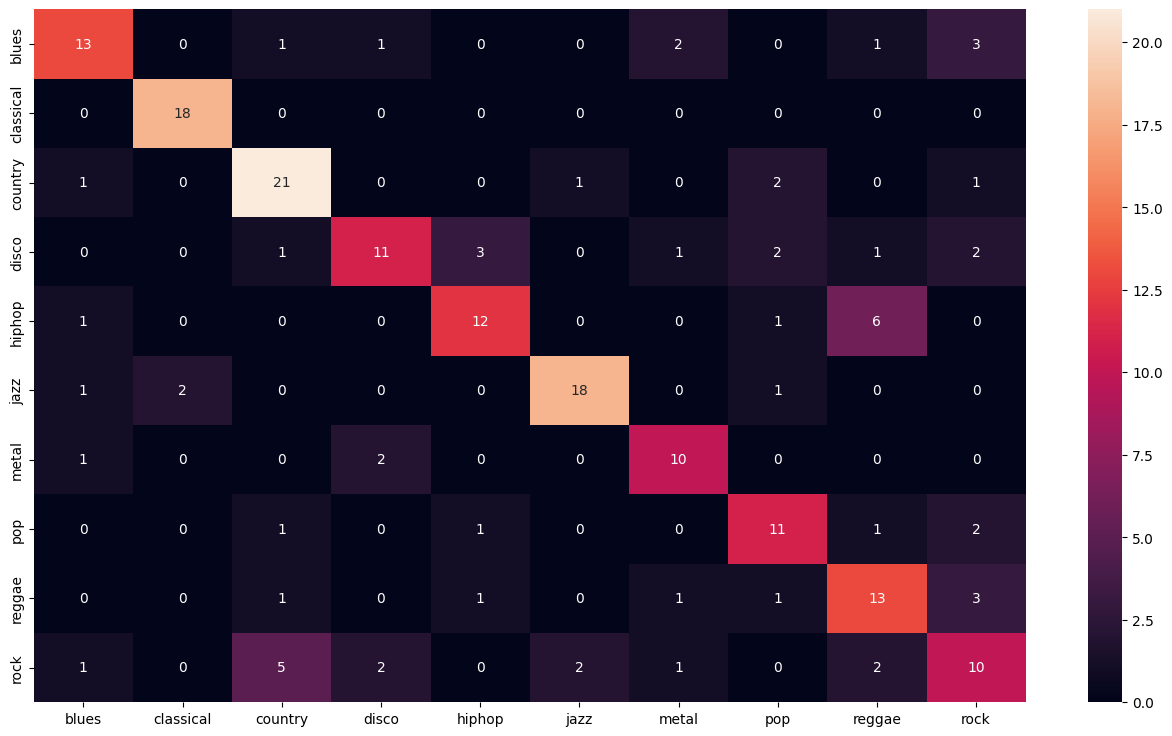

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(16, 9))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
    yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
)
plt.show()

### XGB model feature 중요도

In [27]:
model_features = zip(X_test.columns, best_xgb_model.feature_importances_)
model_features = sorted(model_features, key=lambda item: item[1], reverse=True)

for feature, importance in model_features:
  print(f"{feature}: {importance: .6f}")

spectral_bandwidth_mean:  0.050982
chroma_stft_mean:  0.036938
chroma_stft_var:  0.035679
rms_mean:  0.034648
rolloff_mean:  0.032050
mfcc4_mean:  0.025424
mfcc5_var:  0.024769
mfcc7_var:  0.023264
rms_var:  0.022817
mfcc1_mean:  0.022392
spectral_centroid_var:  0.022233
mfcc4_var:  0.021830
mfcc20_var:  0.020950
mfcc9_mean:  0.020459
rolloff_var:  0.020347
spectral_centroid_mean:  0.019805
harmony_var:  0.019166
zero_crossing_rate_mean:  0.018985
mfcc10_var:  0.018131
mfcc6_var:  0.018015
mfcc12_mean:  0.017887
mfcc8_var:  0.017808
tempo:  0.017060
mfcc1_var:  0.016976
zero_crossing_rate_var:  0.016406
mfcc8_mean:  0.016263
harmony_mean:  0.016133
mfcc6_mean:  0.015715
mfcc2_mean:  0.015709
mfcc17_mean:  0.015569
mfcc9_var:  0.015123
mfcc13_var:  0.014857
mfcc19_var:  0.014783
mfcc13_mean:  0.014766
mfcc3_var:  0.014741
mfcc7_mean:  0.014559
mfcc15_mean:  0.014532
mfcc5_mean:  0.014525
mfcc12_var:  0.014419
spectral_bandwidth_var:  0.014412
mfcc11_mean:  0.013955
mfcc11_var:  0.013259

## LigthGBM

In [28]:
from lightgbm import LGBMClassifier
import joblib


lgbm = LGBMClassifier(verbose=-1, random_state=SEED)

param_distributions = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'num_leaves': [20, 40, 60, 80],  # max_depth에 따라 조정
    'colsample_bytree': [0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1],
    'force_col_wise': [True],  # 오버헤드 제거
}

random_search_lgb = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=10,  # 시도할 하이퍼파라미터 조합 수
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=SEED
)

random_search_lgb.fit(X_train, y_train)

# 결과 출력
print(f"Best parameters found: {random_search_lgb.best_params_}")
print(f"Best CV score: {random_search_lgb.best_score_}")

# 최적의 하이퍼파라미터로 학습된 모델을 저장
best_lgb_model = random_search_lgb.best_estimator_
joblib.dump(best_lgb_model, f'{MODELS}/lgb_model.joblib') # joblib.load() 사용

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 1, 'num_leaves': 20, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.1, 'force_col_wise': True, 'colsample_bytree': 0.7}
Best CV score: 0.7137412820440615


['Cache//lgb_model.joblib']

### Cross Validation of LGB

In [29]:
y_pred = best_lgb_model.predict(X_test)
y_test = label_encoder.inverse_transform(y_test_encoded)
test_accuracy = accuracy_score(y_test, y_pred)
cross_val_accuracy = cross_val_score(lgbm, X, y_encoded, cv=5, n_jobs=-1)

print(f"Test set Accuracy: {test_accuracy * 100:.2f}%")
print(f'Mean CV Accuracy: {cross_val_accuracy.mean() * 100:.2f}%')

Test set Accuracy: 68.00%
Mean CV Accuracy: 58.50%


### Confusion Matrix of LGB

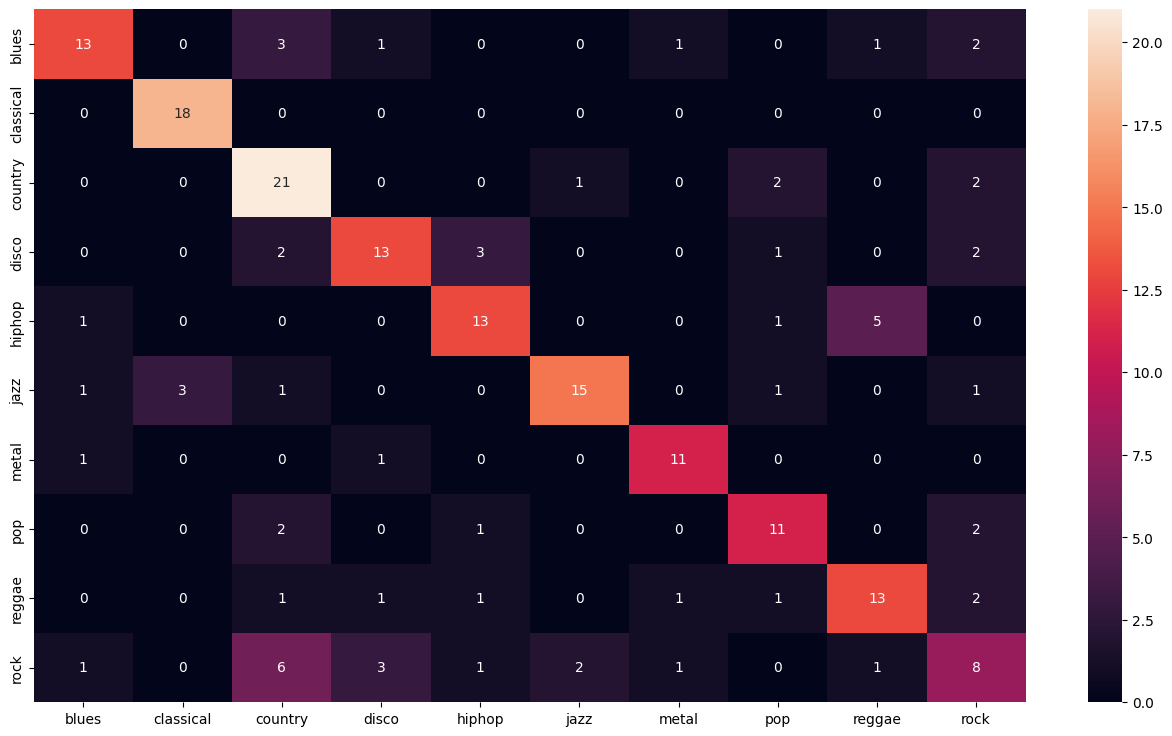

In [30]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(16, 9))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
    yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
)
plt.show()

### LGB model feature 중요도

In [31]:
model_features = zip(X_test.columns, best_lgb_model.feature_importances_)
model_features = sorted(model_features, key=lambda item: item[1], reverse=True)

for feature, importance in model_features:
  print(f"{feature}: {importance}")

chroma_stft_mean: 756
rms_var: 592
harmony_mean: 590
chroma_stft_var: 500
mfcc4_mean: 487
rms_mean: 448
mfcc9_mean: 420
mfcc6_mean: 399
spectral_centroid_var: 398
harmony_var: 383
mfcc17_mean: 383
mfcc12_mean: 381
mfcc7_var: 380
mfcc4_var: 365
mfcc1_mean: 363
mfcc5_var: 363
mfcc3_mean: 360
zero_crossing_rate_mean: 353
tempo: 352
mfcc3_var: 348
mfcc1_var: 332
spectral_bandwidth_mean: 330
rolloff_var: 329
mfcc11_mean: 324
mfcc6_var: 322
mfcc5_mean: 314
mfcc7_mean: 312
mfcc20_mean: 312
mfcc15_mean: 305
mfcc2_mean: 301
mfcc20_var: 296
mfcc10_var: 290
mfcc16_mean: 281
mfcc8_mean: 278
mfcc18_mean: 278
zero_crossing_rate_var: 273
rolloff_mean: 269
spectral_centroid_mean: 260
mfcc18_var: 260
mfcc19_mean: 260
mfcc19_var: 259
mfcc9_var: 255
mfcc14_mean: 251
mfcc10_mean: 249
mfcc13_mean: 232
mfcc17_var: 229
mfcc16_var: 224
mfcc12_var: 220
mfcc8_var: 217
spectral_bandwidth_var: 215
mfcc2_var: 215
mfcc13_var: 211
mfcc11_var: 193
mfcc15_var: 179
mfcc14_var: 135


## CatBoost

In [32]:
from catboost import CatBoostClassifier
import joblib


cat = CatBoostClassifier(random_state=SEED)

param_distributions = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

random_search_cat = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_distributions,
    n_iter=10,  # 시도할 하이퍼파라미터 조합 수
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=SEED
)

random_search_cat.fit(X_train, y_train)

# 결과 출력
print(f"Best parameters found: {random_search_cat.best_params_}")
print(f"Best CV score: {random_search_cat.best_score_}")

# 최적의 하이퍼파라미터로 학습된 모델을 저장
best_cat_model = random_search_cat.best_estimator_
joblib.dump(best_cat_model, f'{MODELS}/cat_model.joblib') # joblib.load() 사용

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 2.2971975	total: 69.1ms	remaining: 34.5s
1:	learn: 2.2906255	total: 88.7ms	remaining: 22.1s
0:	learn: 2.2959390	total: 80.2ms	remaining: 40s
2:	learn: 2.2837030	total: 103ms	remaining: 17.1s
0:	learn: 2.2581729	total: 79ms	remaining: 1m 18s
1:	learn: 2.2894316	total: 117ms	remaining: 29.2s
3:	learn: 2.2763470	total: 130ms	remaining: 16.1s
1:	learn: 2.1968555	total: 120ms	remaining: 59.6s
2:	learn: 2.2829664	total: 163ms	remaining: 27s
4:	learn: 2.2694742	total: 194ms	remaining: 19.2s
2:	learn: 2.1515550	total: 169ms	remaining: 56.3s
0:	learn: 2.2961322	total: 153ms	remaining: 1m 16s
0:	learn: 2.2785204	total: 161ms	remaining: 15.9s
0:	learn: 2.2809437	total: 176ms	remaining: 17.5s
3:	learn: 2.1119448	total: 210ms	remaining: 52.2s
3:	learn: 2.2767370	total: 230ms	remaining: 28.5s
0:	learn: 2.2650767	total: 146ms	remaining: 2m 26s
0:	learn: 2.2967581	total: 192ms	remaining: 3m 12s
1:	learn: 2.2881049	total: 196ms	rema

/Users/chan/graduation_project/1st_semester/spring-semester-project/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


102:	learn: 1.8169169	total: 12.2s	remaining: 1m 46s
178:	learn: 0.5725773	total: 12.3s	remaining: 56.3s
182:	learn: 1.4914509	total: 12.3s	remaining: 21.4s
178:	learn: 1.5426042	total: 12.4s	remaining: 22.2s
99:	learn: 1.8253382	total: 12.3s	remaining: 1m 50s
97:	learn: 1.1567409	total: 12.3s	remaining: 251ms
101:	learn: 1.7938595	total: 12.3s	remaining: 1m 48s
187:	learn: 1.5246296	total: 12.3s	remaining: 20.5s
179:	learn: 0.5702861	total: 12.3s	remaining: 56.1s
177:	learn: 0.5335967	total: 12.3s	remaining: 57s
182:	learn: 0.5802390	total: 12.3s	remaining: 54.8s
179:	learn: 1.5399067	total: 12.4s	remaining: 22.1s
183:	learn: 1.4886098	total: 12.4s	remaining: 21.3s
188:	learn: 1.5224414	total: 12.4s	remaining: 20.4s
183:	learn: 0.5791277	total: 12.3s	remaining: 54.7s
178:	learn: 0.5299563	total: 12.4s	remaining: 56.9s
98:	learn: 1.1519160	total: 12.4s	remaining: 125ms
103:	learn: 1.8132071	total: 12.4s	remaining: 1m 46s
180:	learn: 0.5666819	total: 12.4s	remaining: 56.1s
180:	learn: 1

['Cache//cat_model.joblib']

### Cross Validation of CatBoost

In [33]:
y_pred = best_cat_model.predict(X_test)
y_test = label_encoder.inverse_transform(y_test_encoded)
test_accuracy = accuracy_score(y_test, y_pred)
cross_val_accuracy = cross_val_score(cat, X, y_encoded, cv=5, n_jobs=-1)

print(f"Test set Accuracy: {test_accuracy * 100:.2f}%")
print(f'Mean CV Accuracy: {cross_val_accuracy.mean() * 100:.2f}%')

Learning rate set to 0.078231
0:	learn: 2.2296275	total: 9.91ms	remaining: 9.9s
1:	learn: 2.1655826	total: 19.4ms	remaining: 9.67s
2:	learn: 2.1004163	total: 29ms	remaining: 9.64s
3:	learn: 2.0475752	total: 39.6ms	remaining: 9.86s
4:	learn: 1.9921350	total: 49.9ms	remaining: 9.93s
5:	learn: 1.9378787	total: 61.5ms	remaining: 10.2s
6:	learn: 1.8747101	total: 75.5ms	remaining: 10.7s
7:	learn: 1.8314446	total: 89.5ms	remaining: 11.1s
8:	learn: 1.7911659	total: 104ms	remaining: 11.5s
9:	learn: 1.7481170	total: 117ms	remaining: 11.6s
10:	learn: 1.7105514	total: 132ms	remaining: 11.8s
11:	learn: 1.6703003	total: 146ms	remaining: 12s
Learning rate set to 0.078231
Learning rate set to 0.078231
12:	learn: 1.6323777	total: 168ms	remaining: 12.8s
0:	learn: 2.2249079	total: 17.6ms	remaining: 17.6s
0:	learn: 2.2392890	total: 37.3ms	remaining: 37.3s
13:	learn: 1.5966889	total: 212ms	remaining: 14.9s
1:	learn: 2.1585618	total: 53.8ms	remaining: 26.9s
1:	learn: 2.1746084	total: 66.1ms	remaining: 33s
1

### Confusion Matrix of CatBoost

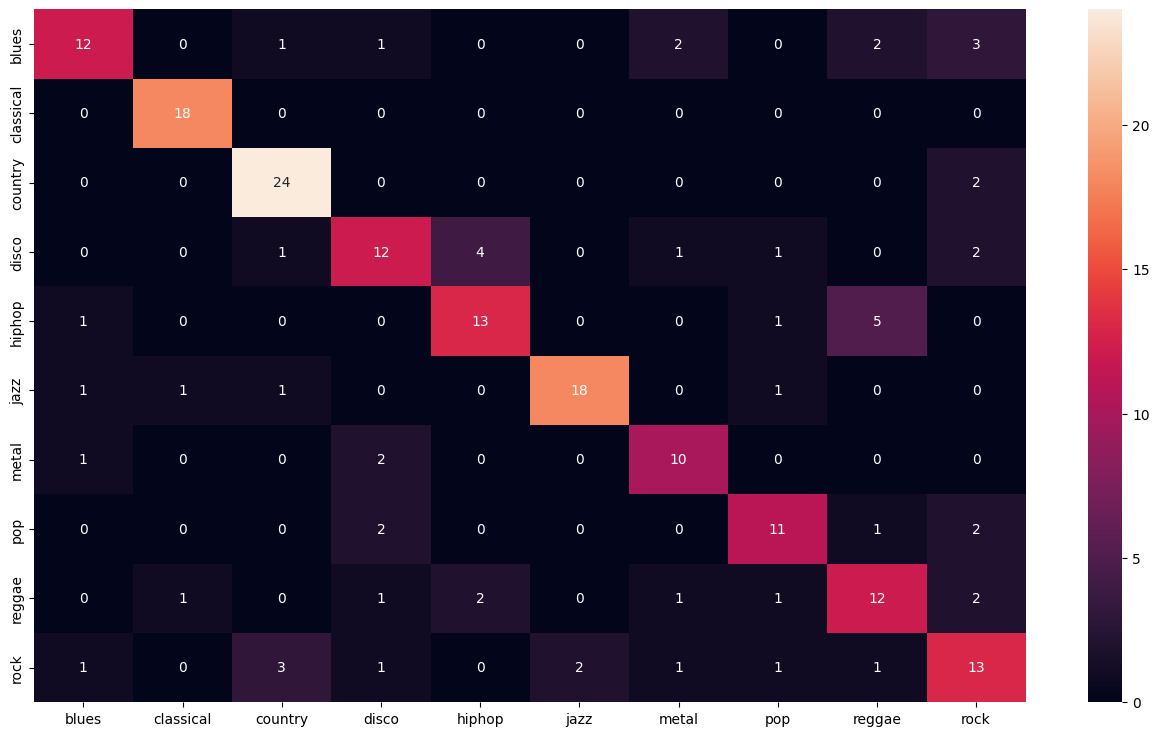

In [34]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(16, 9))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
    yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
)
plt.show()

### CatBoost model feature 중요도

In [35]:
model_features = zip(X_test.columns, best_cat_model.feature_importances_)
model_features = sorted(model_features, key=lambda item: item[1], reverse=True)

for feature, importance in model_features:
  print(f"{feature}: {importance}")

chroma_stft_mean: 9.154659892334152
rms_var: 4.851259402125227
mfcc4_mean: 4.351165514660119
spectral_centroid_var: 3.8475207113455663
harmony_mean: 3.266128137010868
mfcc1_mean: 3.2228305343411248
rms_mean: 2.826765026154293
mfcc6_mean: 2.7583993117865937
spectral_centroid_mean: 2.724379625201519
harmony_var: 2.710282291651923
mfcc4_var: 2.6970020845233695
chroma_stft_var: 2.6545706959793347
mfcc7_var: 2.2620710535830093
mfcc3_mean: 2.241061056240003
mfcc5_var: 2.2319080299451537
rolloff_mean: 2.1240683775108726
mfcc20_var: 2.089002724135114
mfcc8_var: 2.082293432986709
mfcc3_var: 2.0319807300834154
mfcc17_mean: 1.910207744621955
mfcc9_mean: 1.9031536349730833
tempo: 1.8575908311664484
mfcc1_var: 1.6431449278935497
mfcc12_mean: 1.6297665050978143
mfcc7_mean: 1.6263034757781345
mfcc19_var: 1.5801001498030085
mfcc8_mean: 1.5796146033946408
mfcc11_mean: 1.5719284209873823
zero_crossing_rate_mean: 1.5033554814725012
zero_crossing_rate_var: 1.4720558329992084
rolloff_var: 1.414143297285504

# 사용자 입력 음원 데이터 feature vector 생성

In [57]:
# Data 디렉토리 내부에 원하는 wav 파일을 넣고 실행.
audio_extensions = ['.mp3', '.wav', '.flac', '.aac']
directory = 'Data'
user_file_name = ""

for root, dirs, files in os.walk(directory):
    for file in files:
        if any(file.endswith(ext) for ext in audio_extensions):
            user_file_name = file
            break  # 첫 번째로 발견된 음원 파일 이름을 저장하고 루프 종료
    if user_file_name:  # 음원 파일을 찾았다면 상위 루프도 종료
        break

print("Found audio file:", user_file_name)

Found audio file: 4.5_Oasis.wav


In [58]:
y, sr = librosa.load(f"Data/{user_file_name}")
print(y, sr)

[ 5.0448534e-13  6.6791017e-13  3.3750780e-13 ...  0.0000000e+00
 -0.0000000e+00  0.0000000e+00] 22050


In [59]:
features = {
    'chroma_stft_mean': np.mean(librosa.feature.chroma_stft(y=y, sr=sr)).astype(np.float64),
    'chroma_stft_var': np.var(librosa.feature.chroma_stft(y=y, sr=sr)).astype(np.float64),
    'rms_mean': np.mean(librosa.feature.rms(y=y), axis=1).astype(np.float64),
    'rms_var': np.var(librosa.feature.rms(y=y), axis=1).astype(np.float64),
    'spectral_centroid_mean': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr), axis=1).astype(np.float64),
    'spectral_centroid_var': np.var(librosa.feature.spectral_centroid(y=y, sr=sr), axis=1).astype(np.float64),
    'spectral_bandwidth_mean': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr), axis=1).astype(np.float64),
    'spectral_bandwidth_var': np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr), axis=1).astype(np.float64),
    'rolloff_mean': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr), axis=1).astype(np.float64),
    'rolloff_var': np.var(librosa.feature.spectral_rolloff(y=y, sr=sr), axis=1).astype(np.float64),
    'zero_crossing_rate_mean': np.mean(librosa.feature.zero_crossing_rate(y), axis=1).astype(np.float64),
    'zero_crossing_rate_var': np.var(librosa.feature.zero_crossing_rate(y), axis=1).astype(np.float64),
    'harmony_mean': np.mean(librosa.effects.harmonic(y), axis=0).astype(np.float64),
    'harmony_var': np.var(librosa.effects.harmonic(y), axis=0).astype(np.float64),
    'tempo': librosa.feature.tempo(y=y, sr=sr)[0].astype(np.float64),
    'mfcc1_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[0], axis=0).astype(np.float64),
    'mfcc1_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[0], axis=0).astype(np.float64),
    'mfcc2_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[1], axis=0).astype(np.float64),
    'mfcc2_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[1], axis=0).astype(np.float64),
    'mfcc3_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[2], axis=0).astype(np.float64),
    'mfcc3_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[2], axis=0).astype(np.float64),
    'mfcc4_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[3], axis=0).astype(np.float64),
    'mfcc4_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[3], axis=0).astype(np.float64),
    'mfcc5_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[4], axis=0).astype(np.float64),
    'mfcc5_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[4], axis=0).astype(np.float64),
    'mfcc6_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[5], axis=0).astype(np.float64),
    'mfcc6_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[5], axis=0).astype(np.float64),
    'mfcc7_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[6], axis=0).astype(np.float64),
    'mfcc7_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[6], axis=0).astype(np.float64),
    'mfcc8_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[7], axis=0).astype(np.float64),
    'mfcc8_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[7], axis=0).astype(np.float64),
    'mfcc9_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[8], axis=0).astype(np.float64),
    'mfcc9_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[8], axis=0).astype(np.float64),
    'mfcc10_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[9], axis=0).astype(np.float64),
    'mfcc10_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[9], axis=0).astype(np.float64),
    'mfcc11_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[10], axis=0).astype(np.float64),
    'mfcc11_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[10], axis=0).astype(np.float64),
    'mfcc12_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[11], axis=0).astype(np.float64),
    'mfcc12_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[11], axis=0).astype(np.float64),
    'mfcc13_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[12], axis=0).astype(np.float64),
    'mfcc13_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[12], axis=0).astype(np.float64),
    'mfcc14_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[13], axis=0).astype(np.float64),
    'mfcc14_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[13], axis=0).astype(np.float64),
    'mfcc15_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[14], axis=0).astype(np.float64),
    'mfcc15_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[14], axis=0).astype(np.float64),
    'mfcc16_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[15], axis=0).astype(np.float64),
    'mfcc16_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[15], axis=0).astype(np.float64),
    'mfcc17_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[16], axis=0).astype(np.float64),
    'mfcc17_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[16], axis=0).astype(np.float64),
    'mfcc18_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[17], axis=0).astype(np.float64),
    'mfcc18_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[17], axis=0).astype(np.float64),
    'mfcc19_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[18], axis=0).astype(np.float64),
    'mfcc19_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[18], axis=0).astype(np.float64),
    'mfcc20_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[19], axis=0).astype(np.float64),
    'mfcc20_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[19], axis=0).astype(np.float64),
    'label': 'rock'
}


In [60]:
for i in features.keys():
    if isinstance(features[i], np.ndarray):
        features[i] = np.float64(features[i].item())    # np.ndarray를 np.float64로 맞춰주기
    print(f"{i} : \t\t{type(features[i])}")

chroma_stft_mean : 		<class 'numpy.float64'>
chroma_stft_var : 		<class 'numpy.float64'>
rms_mean : 		<class 'numpy.float64'>
rms_var : 		<class 'numpy.float64'>
spectral_centroid_mean : 		<class 'numpy.float64'>
spectral_centroid_var : 		<class 'numpy.float64'>
spectral_bandwidth_mean : 		<class 'numpy.float64'>
spectral_bandwidth_var : 		<class 'numpy.float64'>
rolloff_mean : 		<class 'numpy.float64'>
rolloff_var : 		<class 'numpy.float64'>
zero_crossing_rate_mean : 		<class 'numpy.float64'>
zero_crossing_rate_var : 		<class 'numpy.float64'>
harmony_mean : 		<class 'numpy.float64'>
harmony_var : 		<class 'numpy.float64'>
tempo : 		<class 'numpy.float64'>
mfcc1_mean : 		<class 'numpy.float64'>
mfcc1_var : 		<class 'numpy.float64'>
mfcc2_mean : 		<class 'numpy.float64'>
mfcc2_var : 		<class 'numpy.float64'>
mfcc3_mean : 		<class 'numpy.float64'>
mfcc3_var : 		<class 'numpy.float64'>
mfcc4_mean : 		<class 'numpy.float64'>
mfcc4_var : 		<class 'numpy.float64'>
mfcc5_mean : 		<class 'nump

## Music Genre Classfication 모델에 대한 예측

In [61]:
features_df = pd.DataFrame([features], index=[user_file_name])
new_song_label = features_df['label']
features_df = features_df.drop(columns=['label'])

In [62]:
with open(f'{MODELS}/scaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)
    
new_data_scaled = loaded_scaler.transform(features_df)

In [63]:
xgb_new = XGBClassifier()
xgb_new.load_model(f'{MODELS}/xgb_model.json')

y_pred = xgb_new.predict(new_data_scaled)
print(label_encoder.inverse_transform(y_pred))

['rock']


In [64]:
lgb_new = joblib.load(f'{MODELS}/lgb_model.joblib')

y_pred = lgb_new.predict(new_data_scaled)
print(y_pred)

['metal']


In [65]:
cat_new = joblib.load(f'{MODELS}/cat_model.joblib')

y_pred = cat_new.predict(new_data_scaled)
print(y_pred)

[['rock']]
